# Sentiment Analysis - Bert Multilingual

#### This notebook aims to process data that has been previously cleaned and provide a specific score for sentiment analysis. Once this score is generated, an accuracy analysis will be performed to check the performance of the applied model.

## Import packages

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from gensim.parsing.preprocessing import remove_stopwords, strip_numeric, strip_punctuation, strip_multiple_whitespaces, strip_short
from sklearn.metrics import confusion_matrix
import os
from sklearn.metrics import classification_report, confusion_matrix

## Load model

The model used is bert-base-multilingual-uncased-sentiment from the hugging face library

In [9]:
# https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment

# Creating the tokenizer for sentiment analysis using the specified pre-trained model
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Creating the model for sequence classification using the specified pre-trained model
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Load data

The data is load, previously cleaned in the preprocessing models. The csv that will be used is data_clean_1. This is a data set cleaned, which only contains the sentence where the player name is. It also contains 30 rows per language which has been manually labeled, to enable later accuracy performance report

The selection of this specific dataset was based on two main factors. Firstly, it aligned with the specifications and examples that the BERT-multilingual model was designed to work with. Secondly, after testing various other cleaned datasets, this particular one demonstrated better accuracy and more reliable results. Some of the other datasets were yielding all positive or all negative results, making this dataset the preferred choice for sentiment analysis.

In [10]:
# Load the CSV file into a DataFrame
df_de = pd.read_csv('../Preprocessing/data_clean/labeled-data/labeled-de_clean_1-1.csv',sep = ';')
#df_en = pd.read_csv('../Preprocessing/data_clean/en_clean_1.csv')
df_en = pd.read_csv('../Preprocessing/data_clean/labeled-data/labeled-en_clean_1-1_not101010.csv')
#df_es = pd.read_csv('../Preprocessing/data_clean/en_clean_1.csv')
df_es = pd.read_csv('../Preprocessing/data_clean/labeled-data/labeled-es_clean_1-1.csv', sep = ';')


We need to remove the punctuation that was still there due to their need for extracting the sentence

In [11]:
# Strip punctuation
df_de['data'] = df_de['data'].apply(strip_punctuation)
df_en['data'] = df_en['data'].apply(strip_punctuation)
df_es['data'] = df_es['data'].apply(strip_punctuation)

# Strip white spaces
df_de['data'] = df_de['data'].apply(strip_multiple_whitespaces)
df_en['data'] = df_en['data'].apply(strip_multiple_whitespaces)
df_es['data'] = df_es['data'].apply(strip_multiple_whitespaces)


## Sentiment Analysis Process

Create a simple function that allows the model to operate for each record in the df

In [12]:
# Definition of function to assign a sentiment score for each record of the df
def sentiment_score(data):
    if isinstance(data, str):
        tokens = tokenizer.encode(data, return_tensors='pt')
        result = model(tokens)
        return int(torch.argmax(result.logits)) + 1
    else:
        return 0

In [13]:
# Runing the funtion sentiment_score for each data set per language
df_de['sentiment'] = df_de['data'].apply(lambda x: sentiment_score(x[:512]))
df_en['sentiment'] = df_en['data'].apply(lambda x: sentiment_score(x[:512]))
df_es['sentiment'] = df_es['data'].apply(lambda x: sentiment_score(x[:512]))

## Translate scores to positive, neutral and negative

In order to compare the results with the manually labled records, the following translation into positive, neutral and negative are needed

In [14]:
# Create a map for distribution
sentiment_mapping = {1: 'negativ', 2: 'neutral', 3: 'neutral', 4: 'neutral', 5: 'positiv'}

# Replace the numbers with labels using the mapping
df_de['sentiment_label'] = df_de['sentiment'].map(sentiment_mapping)
df_en['sentiment_label'] = df_en['sentiment'].map(sentiment_mapping)
df_es['sentiment_label'] = df_es['sentiment'].map(sentiment_mapping)

## Save data

Once all sentiment scores have been added, the data needs to be stored for later analysis

In [11]:
# Concatenate the dataframes vertically
merged_df = pd.concat([df_de, df_en, df_es], ignore_index=True)

# Create the folder if it doesn't exist
folder_name = 'data'

# Define the file path for saving the CSV
file_name = 'data_sentiment_final.csv'
file_path = os.path.join(folder_name, file_name)

# Convert the dataframe to CSV and save it
merged_df.to_csv(file_path, index=False)

## Accuracy Performance Analysis

Using the manually labeled rows an accuracy performance analysis is needed. The base for this analysis is the confusion matrix. The perofrmance per language per category, taking into acount f1, precision and recall

In [15]:
# Drop rows where 'Label' is NaN or empty
df_de.dropna(subset=['Label'], inplace=True)
df_en.dropna(subset=['Label'], inplace=True)
df_es.dropna(subset=['Label'], inplace=True)

## Accuracy for exact match

This accuracy measure captures the exact match, indicating that the manually given label exactly matches the predicted-mapped label. In other words, it evaluates how many predicted labels are precisely the same as the ground-truth (manually assigned) labels.

In [16]:
# Calculate the accuracy
accuracy_de = (df_de['sentiment_label'] == df_de['Label']).mean() * 100
accuracy_en = (df_en['sentiment_label'] == df_en['Label']).mean() * 100
accuracy_es = (df_es['sentiment_label'] == df_es['Label']).mean() * 100

# Print the accuracy
print("Accuracy DE: {:.2f}%".format(accuracy_de))
print("Accuracy EN: {:.2f}%".format(accuracy_en))
print("Accuracy ES: {:.2f}%".format(accuracy_es))

Accuracy DE: 56.67%
Accuracy EN: 46.67%
Accuracy ES: 43.33%


## Classification report DE

In [17]:
# Extracting the actual sentiment labels
actual_labels = df_de['Label']

# Extracting the predicted sentiment labels
predicted_labels = df_de['sentiment_label']

# Calculating the classification report based on the actual and predicted sentiment labels
report = classification_report(actual_labels, predicted_labels)

# Displaying the classification report which includes precision, recall, F1-score
print(report)

              precision    recall  f1-score   support

     negativ       0.56      0.50      0.53        10
     neutral       0.53      0.80      0.64        10
     positiv       0.67      0.40      0.50        10

    accuracy                           0.57        30
   macro avg       0.59      0.57      0.56        30
weighted avg       0.59      0.57      0.56        30



## Classification report EN

In [18]:
# Extracting the actual sentiment labels
actual_labels = df_en['Label']

# Extracting the predicted sentiment labels
predicted_labels = df_en['sentiment_label']

# Calculating the classification report based on the actual and predicted sentiment labels
report = classification_report(actual_labels, predicted_labels)

# Displaying the classification report which includes precision, recall, F1-score
print(report)

              precision    recall  f1-score   support

     negativ       0.31      1.00      0.47         4
     neutral       0.62      0.62      0.62        13
     positiv       0.50      0.15      0.24        13

    accuracy                           0.47        30
   macro avg       0.47      0.59      0.44        30
weighted avg       0.52      0.47      0.43        30



## Classification report ES

In [19]:
# Extracting the actual sentiment labels
actual_labels = df_es['Label']

# Extracting the predicted sentiment labels
predicted_labels = df_es['sentiment_label']

# Calculating the classification report based on the actual and predicted sentiment labels
report = classification_report(actual_labels, predicted_labels)

# Displaying the classification report which includes precision, recall, F1-score
print(report)


              precision    recall  f1-score   support

     negativ       0.42      0.50      0.45        10
     neutral       0.44      0.80      0.57        10
     positiv       0.00      0.00      0.00        10

    accuracy                           0.43        30
   macro avg       0.29      0.43      0.34        30
weighted avg       0.29      0.43      0.34        30



/Users/galachaparro/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/galachaparro/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/galachaparro/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

## Classification report overall

In [20]:
#Concatenate the dataframes vertically
merged_df = pd.concat([df_de, df_en, df_es], ignore_index=True)

# Extracting the actual sentiment labels
actual_labels = merged_df['Label']

# Extracting the predicted sentiment labels
predicted_labels = merged_df['sentiment_label']

# Calculating the classification report based on the actual and predicted sentiment labels
report = classification_report(actual_labels, predicted_labels)

# Displaying the classification report which includes precision, recall, F1-score
print(report)

              precision    recall  f1-score   support

     negativ       0.41      0.58      0.48        24
     neutral       0.52      0.73      0.61        33
     positiv       0.60      0.18      0.28        33

    accuracy                           0.49        90
   macro avg       0.51      0.50      0.46        90
weighted avg       0.52      0.49      0.45        90



# Notebook Output

This notebook creates a CSV file that will contain the sentiment score and label predicted by the model for each row of data. Simultaneously, this provides us with information on the accuracy of the model for each language and overall performance.

If you are interested in understanding why we did not choose to use the data set "data_condensed," we have further developments and explanations after this notebook summary. These additional details provide insights into the decision-making process and the reasons behind the choices made regarding the data selection.

# Next steps for Buyer04

As the next steps for Buyer04, we would recommend exploring other models that are specifically designed for accurate analysis in the context of sports news. Different models might offer better performance and results for sentiment analysis in this domain. 

Fine-tuning a sentiment model should also be tried out. 

Another approach to improve accuracy is to find the most suitable way to map the sentiment scores into the labels positive, negative, and neutral. Fine-tuning this mapping process based on the specific characteristics of sports news data may lead to more precise sentiment predictions and better overall performance of the sentiment analysis system.

# -----------------------------------

# Data condensed analysis

## Load data

Load data_condensed to check performance of bert-multilingual model assigning sentiment score

In [24]:
# Load data condensed
df_de_con = pd.read_csv('https://raw.githubusercontent.com/svisel22/SS23-BIPM-Analytics-Lab---Group-4-repository/main/Preprocessing/data_clean/de_clean_condensed.csv')
df_en_con = pd.read_csv('https://raw.githubusercontent.com/svisel22/SS23-BIPM-Analytics-Lab---Group-4-repository/main/Preprocessing/data_clean/en_clean_condensed_punc_play.csv')
df_es_con = pd.read_csv('https://raw.githubusercontent.com/svisel22/SS23-BIPM-Analytics-Lab---Group-4-repository/main/Preprocessing/data_clean/es_clean_condensed.csv')

## Sentiment analysis

Run sentiment analysis bert-multilingual model

In [25]:
# Runing the funtion sentiment_score for each data set per language
df_de_con['sentiment'] = df_de_con['data'].apply(lambda x: sentiment_score(x[:512]))
df_en_con['sentiment'] = df_en_con['data'].apply(lambda x: sentiment_score(x[:512]))
df_es_con['sentiment'] = df_es_con['data'].apply(lambda x: sentiment_score(x[:512]))

## Results analysis

The accuracy report cannot be generated for "data_clean_1-1" since manual labeling was not performed. However, we are evaluating the sentiment scores given by the model by grouping them based on the mean per player. Subsequently, we plot the results to observe the distribution and representation of scores per player. This analysis allows us to gain insights into the sentiment tendencies for different players in the dataset.

The following results indicate a very low sentiment tendency among all the players and languages, especially for the Spanish data. This is in contrast to what we typically read in the news, where the perceived sentiment in Spanish is mostly positive. The observed discrepancy between the sentiment scores from the model and the expected sentiment based on news reports is noteworthy and requires further investigation.

In [26]:
# Grouping the data by 'player' and calculating the mean of 'sentiment' for each player
mean_sentiment_de_con = df_de_con.groupby('player')['sentiment'].mean()
mean_sentiment_en_con = df_en_con.groupby('player')['sentiment'].mean()
mean_sentiment_es_con = df_es_con.groupby('player')['sentiment'].mean()

print('Sentiment score per player DE')
print(mean_sentiment_de_con)
print('Sentiment score per player EN')
print(mean_sentiment_en_con)
print('Sentiment score per player ES')
print(mean_sentiment_es_con)

Sentiment score per player DE
player
exequiel palacios    1.833333
jeremie frimpong     1.939130
jonathan tah         2.223529
mitchel bakker       2.000000
moussa diaby         2.058824
mykhaylo mudryk      1.111111
piero hincapie       1.646341
Name: sentiment, dtype: float64
Sentiment score per player EN
player
exequiel palacios    1.814815
jeremie frimpong     2.041667
jonathan tah         2.000000
mitchel bakker       2.909091
moussa diaby         1.815603
mykhaylo mudryk      1.777778
piero hincapie       1.857143
Name: sentiment, dtype: float64
Sentiment score per player ES
player
exequiel palacios    1.422680
jeremie frimpong     1.869565
jonathan tah         1.666667
mitchel bakker       1.545455
moussa diaby         1.193548
mykhaylo mudryk      1.148148
piero hincapie       1.800000
piero hincapié       1.698630
Name: sentiment, dtype: float64


Sentiment score distribution per language

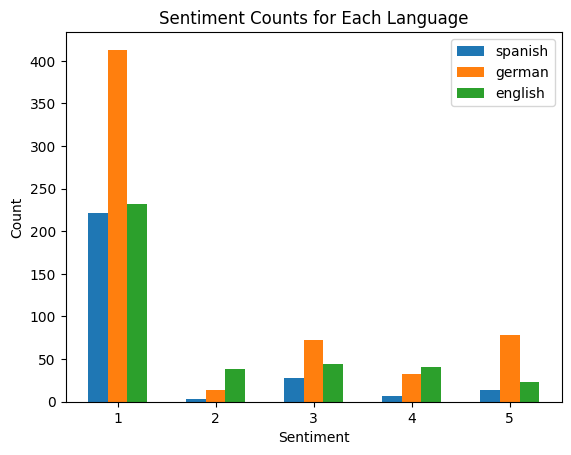

In [27]:
# Calculate the count of each sentiment category for each DataFrame
es_sentiment_counts_con = df_es_con['sentiment'].value_counts().sort_index()
de_sentiment_counts_con = df_de_con['sentiment'].value_counts().sort_index()
en_sentiment_counts_con = df_en_con['sentiment'].value_counts().sort_index()

# Set the x-axis labels
sentiment_labels = ['1', '2', '3', '4', '5']
x = np.arange(len(sentiment_labels))

# Set the width of each bar
bar_width = 0.2

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the counts for each sentiment category for each DataFrame
ax.bar(x - bar_width, es_sentiment_counts_con, width=bar_width, label='spanish')
ax.bar(x, de_sentiment_counts_con, width=bar_width, label='german')
ax.bar(x + bar_width, en_sentiment_counts_con, width=bar_width, label='english')

# Set the x-axis ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(sentiment_labels)

# Set the plot title and labels
ax.set_title('Sentiment Counts for Each Language')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In the following step, we review the score distribution across the different languages. It is evident that the dataset, regardless of the language, is mostly labeled as having a negative sentiment with a score of 1. This contradicts what we typically read in the news, as all the languages do not reflect such a negative sentiment.